### Preprocessing

In [1]:
import os
os.chdir("..")

In [2]:
import pandas as pd
import numpy as np
import importlib, glob, pickle, torch, logging
from datetime import datetime
from concurrent import futures
from tqdm import tqdm

from src.data.insert_ids import insert_ids_in_folder
from src.data.rename_logos import rename_logos
from src.data.get_svg_meta_data import get_svg_meta_data
from src.data.generate_random_animations import random_animation_vector
from src.data.expand_viewbox import expand_viewbox_in_folder

from src.preprocessing.sort_paths import sort_by_relevance
from src.preprocessing.decompose_logo import decompose_logos_in_folder
from src.preprocessing.create_svg_embedding import _load_model, apply_embedding_model_to_svgs, combine_embeddings, encode_svg, decode_z
from src.preprocessing.deepsvg.svglib.svg import SVG
from src.preprocessing.deepsvg import utils

from src.features.get_style_attributes import *

from src.models_output.insert_animation import create_animated_svg
from src.models_output.transform_animation_predictor_output import transform_animation_predictor_output

#### 1 Rename and insert IDs in SVGs
Logos are renamed and an ID called animation_id is inserted for every path in a SVG.

In [8]:
expand_viewbox_in_folder('data/initial_svgs', 50, "data/svgs_expanded")

In [3]:
rename_logos("data/svgs_without_docstring_old", "data/svgs_without_docstring")

In [4]:
insert_ids_in_folder("data/svgs_expanded_renamed", "data/svgs")

#### 2 Decompose SVGs
Decompose SVGs by saving every path in a seperate SVG file. Decomposed SVGs are save to data/decomposed_svgs.

In [3]:
decompose_logos_in_folder("data/svgs")

#### 3 Simplify SVGs
Creates simplified SVGs and its tensors on SVG and path level  
###### UPDATE: NOT NEEDED ANYMORE

In [7]:
preprocess_folder(data_folder="data/svgs")

100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:54<00:00,  3.52it/s]


In [8]:
preprocess_folder(data_folder="data/decomposed_svgs")

100%|██████████████████████████████████████████████████████████████████████████████| 5109/5109 [02:42<00:00, 31.53it/s]


#### 4 Get SVGs Metadata

In [3]:
pd.set_option('display.max_rows', None)

In [3]:
#meta_data = get_svg_meta_data("data/truncated_svgs")
#meta_data

In [5]:
meta_data.to_csv("data/meta_data/truncated_svgs_meta.csv", index=False)

In [5]:
output = open("data/meta_data/svgs_metadata.csv", 'wb')
pickle.dump(meta_data, output)
output.close()

#### 5 Get Path Embeddings
Apply hierarchical generative network to produce latent vector z

In [37]:
model = "models/hierarchical_ordered.pth.tar"

In [3]:
apply_embedding_model_to_svgs(data_folder="data/decomposed_svgs", split_paths=True, save=True)

100%|██████████████████████████████████████████████████████████████████████████████| 5109/5109 [04:03<00:00, 20.96it/s]


,filename,animation_id,0,1,2,3,4,5,6,7,...,246,247,248,249,250,251,252,253,254,255
0,logo_0,0,0.789936,-0.786410,-0.309709,1.362506,-0.290023,1.017092,-0.394151,-1.450244,...,0.525660,-0.590144,-0.130421,0.159403,-0.080556,-0.729687,-1.473149,0.363847,0.311790,-0.102659
1,logo_0,1,0.760854,-1.654953,0.728048,-0.192816,-0.039667,0.104971,-1.947641,-1.436980,...,-1.857717,-1.807807,0.185051,-0.410260,0.014543,-1.204671,-1.092592,0.305544,-0.936117,0.379724
2,logo_0,2,0.307773,-0.866350,1.712584,-0.459635,-0.900046,0.969765,-0.638381,0.001584,...,-1.170392,-1.855947,0.057350,1.037182,0.677306,-1.379392,-0.026326,-0.223816,0.420645,0.522583
3,logo_0,3,0.528505,-0.911613,0.602297,-0.442352,-0.372940,1.294093,-0.408200,-0.682398,...,-0.425637,-2.302075,-0.129217,2.311255,1.090291,-1.182295,-0.546159,-0.642711,1.271445,-0.008963
4,logo_0,4,0.695670,-0.992455,1.348206,0.514868,-0.692438,0.797865,-1.285720,-1.061482,...,-0.817720,-1.304439,-0.204704,-0.408743,-0.001847,-1.304837,-0.860594,-0.277987,-0.500708,0.370812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5091,logo_9,7,1.553792,-1.891178,1.094221,0.630885,0.263913,1.636845,-0.907697,-0.362863,...,0.315695,-2.966342,-0.779966,2.444190,1.213309,-0.913385,-0.619866,-0.558984,0.800450,-0.442717
5092,logo_9,5,0.540934,-2.451702,1.391917,-0.105627,0.123784,0.203037,-2.324454,-0.550153,...,-2.740619,-3.563829,0.353924,1.167960,1.002982,-1.359028,-0.365924,0.561010,-0.733964,0.706526
5093,logo_9,6,0.556691,-1.223028,1.289592,-0.755437,-0.606246,-0.374411,-1.592816,-0.272624,...,-2.596577,-4.103380,-0.054173,0.425820,0.896809,-1.854174,-0.708441,0.120277,-0.154614,1.105704
5094,logo_9,4,1.010776,-1.187377,0.731911,-0.458199,-0.557817,0.759733,-1.248586,-0.026511,...,-1.623372,-3.768194,-0.259169,1.375822,1.349172,-1.630144,-0.534741,-0.258171,-0.047301,0.360815


In [4]:
with open('data/embeddings/path_embedding.pkl', 'rb') as f:
    path_embedding = pickle.load(f)

In [7]:
#path_embedding#[path_embedding['filename'] == 'logo_173']

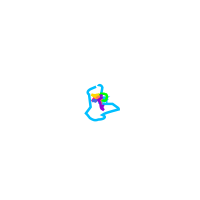

In [8]:
file = "data/decomposed_svgs/logo_37_0.svg"
z = encode_svg(filename = file, data_folder="data/decomposed_svgs", split_paths=True)
decode_z(z)

In [7]:
path_embedding[path_embedding["filename"]=="logo_37"]

,filename,animation_id,0,1,2,3,4,5,6,7,...,246,247,248,249,250,251,252,253,254,255
3347,logo_37,1,0.767400,-0.721387,1.061528,0.003936,-0.763221,0.946376,-0.584684,0.155355,...,-0.706007,-4.024151,-0.781994,2.090312,1.655304,-1.582091,-0.877338,-0.383140,1.191025,0.626104
3348,logo_37,0,-0.710858,0.744055,0.604283,-0.035496,-0.304608,-0.678038,-1.810309,0.697621,...,-1.468121,-2.331798,0.060613,-0.708045,1.078953,-0.127769,-0.512694,-0.213201,-0.861069,0.867309
3349,logo_37,2,0.934483,-1.500365,0.345049,1.193101,-0.222080,2.321496,-0.127838,-0.189523,...,0.653853,-2.367182,-0.568107,2.244652,1.323835,-0.971887,-0.233364,-0.033162,0.490277,-0.548831
3350,logo_37,3,0.862654,0.758955,1.207540,0.280837,-1.033720,-0.889414,-0.064494,0.627098,...,0.059904,-3.522466,-0.796674,0.659970,0.703120,-1.381968,-1.048746,-1.082791,1.963104,1.536288
3351,logo_37,4,0.630766,-1.830302,1.038555,-0.023010,-0.236880,0.335377,-2.143478,-0.531440,...,-2.428053,-3.670521,0.054944,1.131150,1.300249,-1.577138,-0.730661,0.238648,-0.320419,0.779200
3352,logo_37,5,0.793476,-2.051907,1.719936,-0.361618,0.243178,0.203739,-1.501255,0.374606,...,-1.921426,-4.063417,-0.301340,3.014966,1.535725,-1.325546,0.085466,-0.159113,1.449858,0.658289
3353,logo_37,6,0.850246,-1.144974,1.541483,-0.708322,-0.564767,-0.426352,-1.658954,0.076475,...,-2.104415,-4.333948,-0.517492,0.683827,1.062232,-1.783375,-0.876368,-0.191316,0.220720,1.248753
3354,logo_37,7,1.035041,-1.251371,1.704273,-1.185156,-0.315921,-0.584747,-1.510706,0.406987,...,-2.036280,-4.517684,-0.547289,1.529623,1.251671,-1.724851,-0.447631,-0.477674,1.017210,1.173916
3355,logo_37,8,0.540563,-0.842945,1.218790,-0.034098,-0.839644,-0.613333,-1.526924,-0.492874,...,-2.363260,-3.793921,-0.167508,-0.737174,0.436461,-1.873134,-1.066989,0.249022,-0.674423,1.273058
3356,logo_37,9,0.919371,-1.422635,1.608101,-1.136602,-0.294888,-0.850390,-1.816382,0.138522,...,-2.505407,-4.274692,-0.391622,0.717872,0.927352,-1.753221,-0.555902,-0.126467,0.327340,1.260000


#### 6 Get Truncated SVG Embedding

In [ ]:
apply_embedding_model_to_svgs(data_folder="data/truncated_svgs", split_paths=False, save=True)

  6%|█████                                                                            | 12/192 [00:00<00:18,  9.70it/s]

In [9]:
with open('data/embeddings/truncated_svg_embedding.pkl', 'rb') as f:
    truncated_svg_embedding = pickle.load(f)

In [10]:
truncated_svg_embedding["logo_id"] = truncated_svg_embedding["filename"].apply(lambda l: int(l.split("_")[-1]) )

In [11]:
truncated_svg_embedding.sort_values(by=['logo_id'])

,filename,0,1,2,3,4,5,6,7,8,...,247,248,249,250,251,252,253,254,255,logo_id
0,logo_0,-0.319286,0.768348,-0.230691,0.507367,-0.075261,1.508813,-0.912999,0.675434,-0.001406,...,-1.237188,-0.534437,-0.611804,1.196366,0.697434,-0.608996,-0.137433,-1.429938,-0.784427,0
2,logo_1,0.336720,1.501473,1.169257,0.030017,-0.814627,1.051143,-0.441092,0.991913,-1.523129,...,-2.788134,-0.738329,0.469090,1.012248,0.454091,-0.068043,-1.105730,0.461207,-0.313481,1
96,logo_4,1.026601,0.503723,0.393026,-0.463900,0.018286,0.778132,0.000968,0.523557,-1.192480,...,-2.094021,0.937697,1.070840,0.847270,0.806781,0.498334,-0.152665,-0.135112,-0.326979,4
107,logo_5,0.618347,1.313700,0.918294,-0.425941,-0.146768,0.430400,0.306780,2.013381,-1.111060,...,-2.927367,-1.322501,-0.160848,1.673383,0.397928,-0.588335,-0.169742,0.305947,-0.501522,5
116,logo_6,0.640700,1.018042,0.267838,-0.324064,-0.437142,0.850384,0.643671,1.262248,-0.953211,...,-0.923869,-0.737705,0.297321,1.181116,-0.196109,-0.455151,0.263948,0.172333,-0.349800,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,logo_187,1.539024,-0.040631,0.393989,0.319893,-1.290616,0.669674,-0.577846,-0.315150,-1.112488,...,-1.373711,0.187085,0.559191,0.778073,-0.717797,0.360962,-0.202559,-0.279704,0.133265,187
73,logo_188,-0.113772,1.393692,-0.200677,1.206145,-0.995082,1.400655,-0.105506,1.488463,-0.449894,...,-0.163678,-1.674516,0.243883,1.770431,-0.551852,-0.358444,-0.326204,0.229872,-0.020805,188
75,logo_189,0.398498,0.701880,0.372359,-0.059786,-0.335600,0.325044,-0.882167,1.376473,-0.090127,...,-0.969852,0.658988,0.247969,1.414171,-0.646614,0.383088,-0.130043,-0.201297,0.442788,189
76,logo_190,0.985857,-0.084097,0.303740,-0.814396,-0.259730,0.269703,-0.343166,1.259054,-0.882186,...,-2.414949,0.998506,1.311748,1.195492,-0.565383,0.687683,-0.570188,0.339194,-0.100368,190


In [37]:
#file = "data/truncated_svgs/logo_1.svg"
#z = encode_svg(filename = file, data_folder="data/truncated_svgs", split_paths=False)
#decode_z(z)

In [ ]:
with open('../../data/animated_svgs_dataframes/1646_animation_vectors.pkl', 'rb') as f:
        animation_df = pickle.load(f)

#### 7 Get Style Attributes
Get local as well as global style attributes of SVGs.

In [7]:
df_local = get_local_style_attributes("data/svgs")
df_global = get_global_style_attributes("data/svgs")

In [8]:
df_all_style_attributes = combine_style_attributes(df_global, df_local)
df_all_style_attributes

,file,animation_id,class_,fill,stroke,stroke_width,opacity,stroke_opacity
0,L_7sins_01.svg,0,st0,#FABB00,#000000,0,1.0,1.0
1,L_7sins_01.svg,1,st1,#C5007B,#000000,0,1.0,1.0
2,L_7sins_01.svg,2,st2,#EC7404,#000000,0,1.0,1.0
3,L_7sins_01.svg,3,st1,#C5007B,#000000,0,1.0,1.0
4,L_7sins_01.svg,4,st2,#EC7404,#000000,0,1.0,1.0
...,...,...,...,...,...,...,...,...
5095,L_Weidenbachhof_9_2.svg,22,st3,#FFFFFF,#000000,0,1.0,1.0
5096,L_Weidenbachhof_9_2.svg,23,st3,#FFFFFF,#000000,0,1.0,1.0
5097,L_Weidenbachhof_9_2.svg,24,st3,#FFFFFF,#000000,0,1.0,1.0
5098,L_Weidenbachhof_9_2.svg,25,st3,#FFFFFF,#000000,0,1.0,1.0


In [ ]:
#df_all_style_attributes.to_csv("data/style_attributes.csv")

In [ ]:
#output = open("data/style_attributes.pkl", 'wb')
#pickle.dump(df_all_style_attributes, output)
#output.close()

#### 8 Insert Animations

In [5]:
file = "data/svgs/L_7sins_02.svg"
animation_id = sort_by_relevance("data/path_selection/L_7sins_02")

In [6]:
for s in range(200):
    model_output = random_animation_vector(8, seed=s)
    create_animated_svg(file, animation_id, model_output, str(s))